Import needed stuff

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc

Downloading data by http request

In [2]:
# reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
# reply.encoding = 'utf-8'
# csv_data = reply.text
# df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)
country_df = pd.read_csv('erasmus_data_clean.csv', sep=';',low_memory=False, header=0)

## Mobility of Countries
In this section we want to analyze how musch different countries are involved in the Erasmus program.

I am not sure there are enought node to have a sensible analysis of the problem.

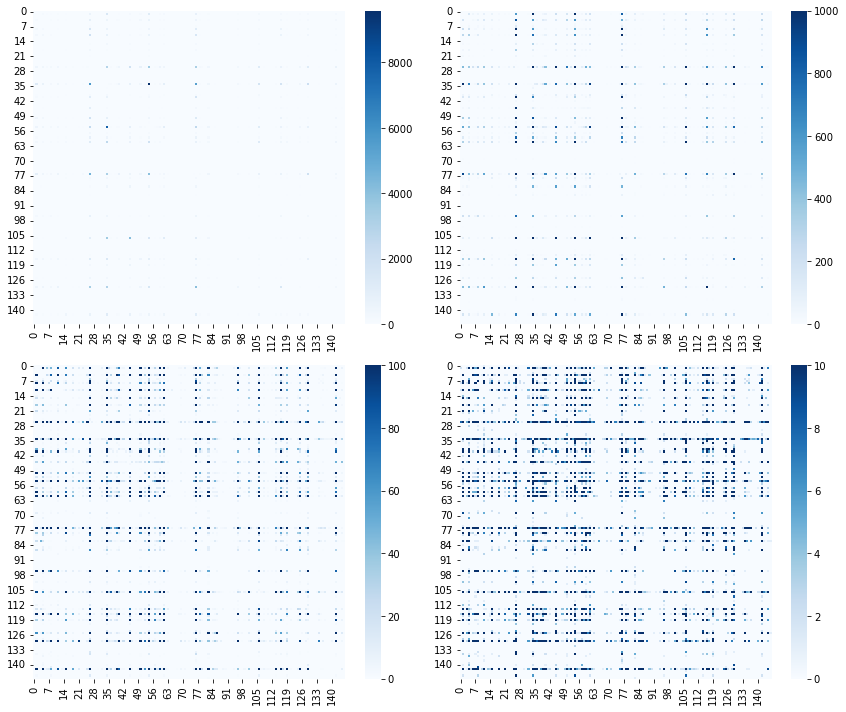

In [3]:
#country_df = df[df[df.columns[10]]=='Learner']
#country_df = country_df.loc[:, df.columns[np.array((14, 17, 20))]]
#country_df.dropna(how='any', inplace=True)
# nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[4]]), set(country_df.loc[:, country_df.columns[5]]))))
country_df.dropna(how='any', inplace=True)
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

def replace_iso3166(alpha):
    try:
        return pc.countries.get(alpha_2=alpha).name
    except:
        return alpha

country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

ns.visualize_adj(adj_matrix_crs)

I would like to understand if the corresponent undirected unwiegthed graph was symmetric, but it is not

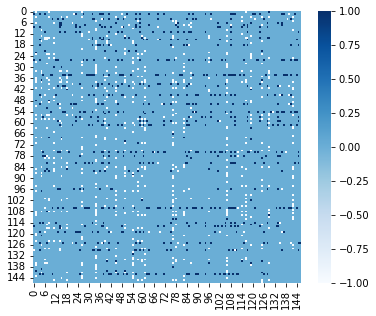

In [4]:
matr = adj_matrix_crs.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()


Calculation of the number of components in the network

In [5]:
country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
components = ns.find_components(adj_matrix_crs, nodes_df)
unique, counts = np.unique(components['component'], return_counts=True)
print('Number of components =', len(unique))

Number of components = 2


### Degree distribution

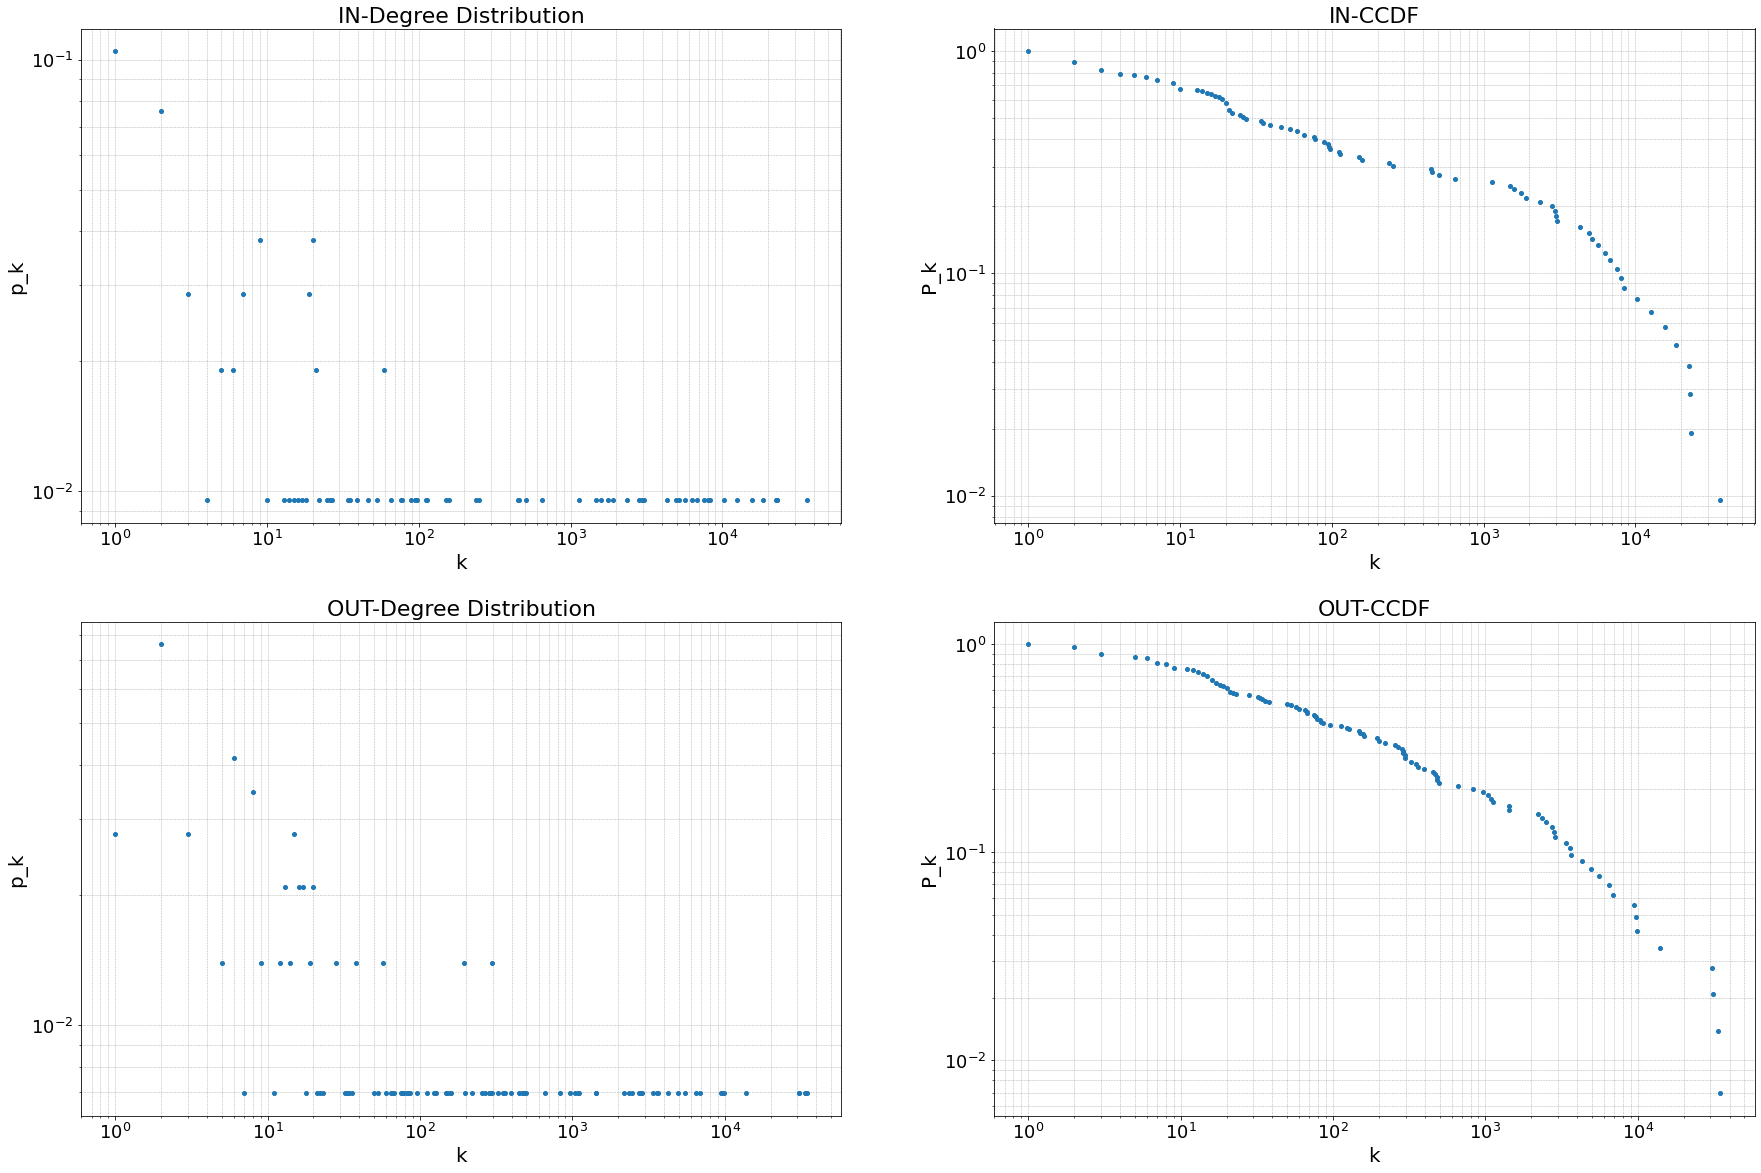

Top 10 for in degree


,Nodes,in degree
34,Spain,36061
76,France,23076
26,Germany,22881
54,Italy,22656
129,UK,18489
106,Poland,15588
61,Portugal,12579
116,Netherlands,10212
142,Czechia,8353
11,Sweden,8069


Top 10 for out degree


,Nodes,out degree
34,Spain,34644
26,Germany,33750
54,Italy,30946
76,France,30586
45,Turkey,13897
116,Netherlands,9824
106,Poland,9781
129,UK,9398
61,Portugal,6864
1,Belgium,6498


In [6]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

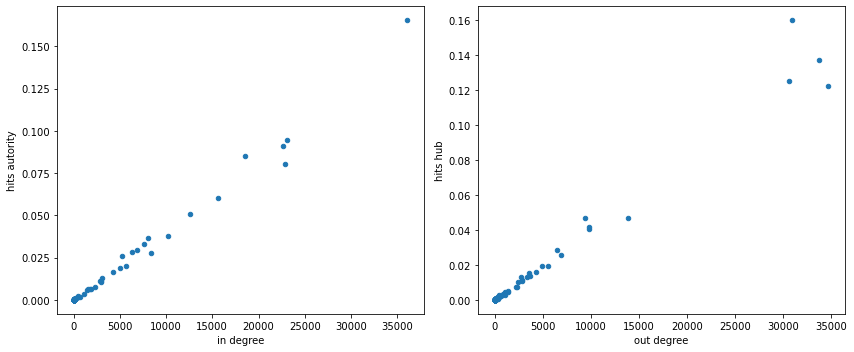

Top 10 for hits hub


,Nodes,hits hub
54,Italy,0.159838
26,Germany,0.137307
76,France,0.124933
34,Spain,0.122427
129,UK,0.046543
45,Turkey,0.046529
116,Netherlands,0.041817
106,Poland,0.040711
1,Belgium,0.028642
61,Portugal,0.025891


Top 10 for hits autority


,Nodes,hits autority
34,Spain,0.165365
76,France,0.094807
54,Italy,0.090851
129,UK,0.085194
26,Germany,0.080147
106,Poland,0.060180
61,Portugal,0.050619
116,Netherlands,0.037963
11,Sweden,0.036765
50,Finland,0.033226


In [7]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

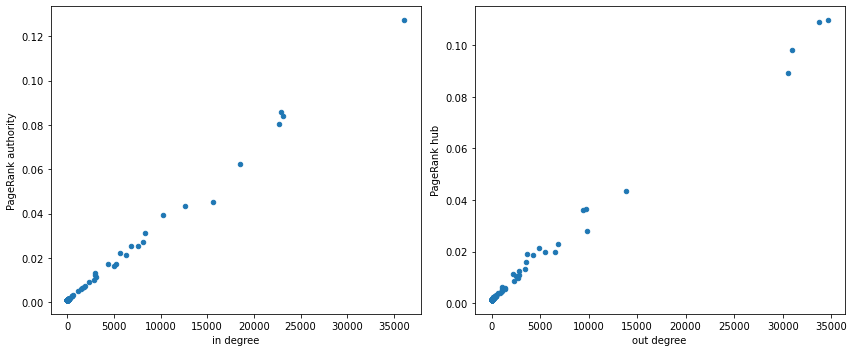

Top 10 for PageRank hub


,Nodes,PageRank hub
34,Spain,0.109555
26,Germany,0.108978
54,Italy,0.097891
76,France,0.089319
45,Turkey,0.043546
106,Poland,0.036413
129,UK,0.036291
116,Netherlands,0.027928
61,Portugal,0.023102
4,Austria,0.021601


Top 10 for PageRank authority


,Nodes,PageRank authority
34,Spain,0.127210
26,Germany,0.086031
76,France,0.084201
54,Italy,0.080548
129,UK,0.062429
106,Poland,0.045424
61,Portugal,0.043197
116,Netherlands,0.039129
142,Czechia,0.031233
11,Sweden,0.027290


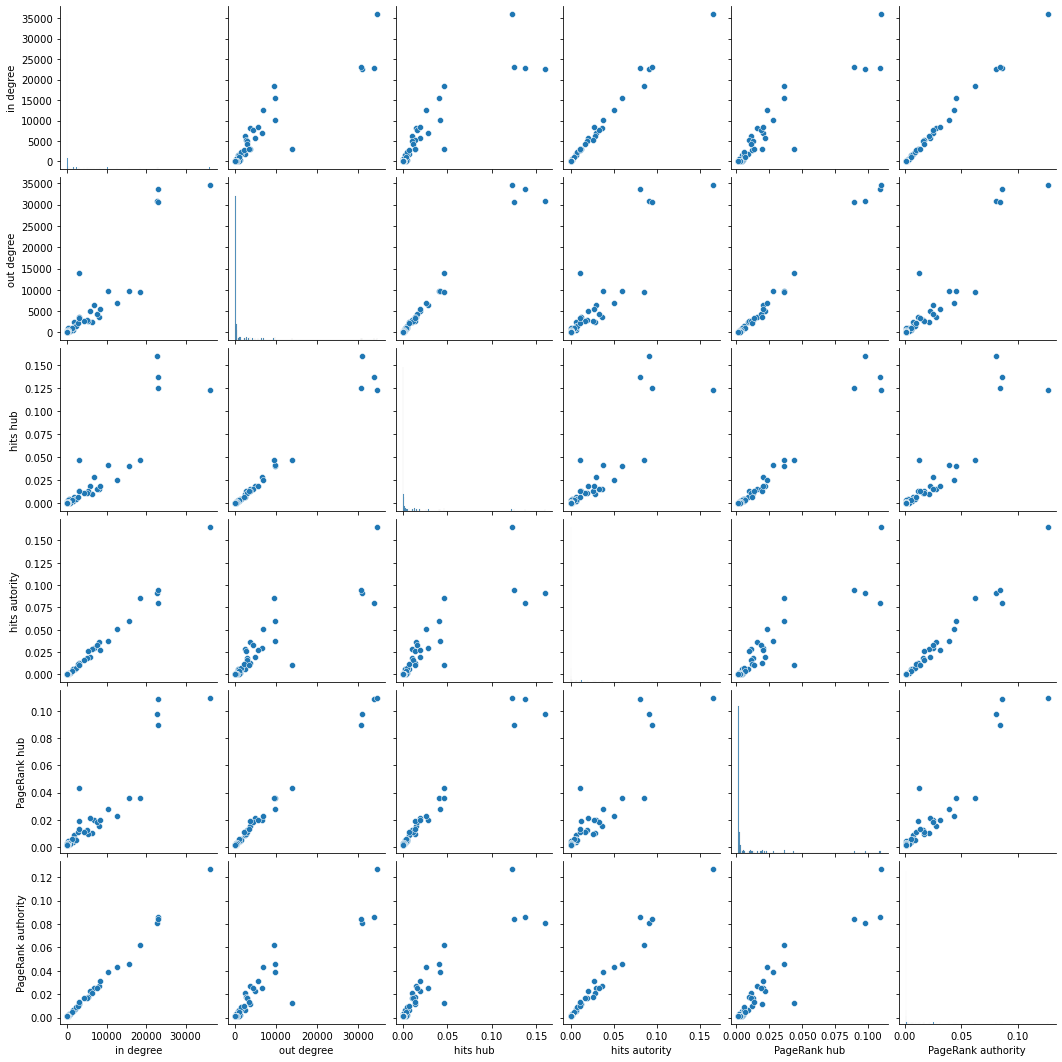

In [8]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank authority')

sns.pairplot(scores)
plt.show()

In [9]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores

scores = create_position(scores, 'in degree')
scores = create_position(scores, 'out degree')
scores = create_position(scores, 'hits hub')
scores = create_position(scores, 'hits autority')
scores = create_position(scores, 'PageRank hub')
scores = create_position(scores, 'PageRank authority')
scores.sort_index(inplace=True)

In [10]:
n = 40
pd.set_option('display.max_rows', n)
display(scores.sort_values('PageRank authority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank authority', 'PageRank authority position']].head(n))
display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))

,Nodes,in degree,in degree position,hits autority,hits autority position,PageRank authority,PageRank authority position
34,Spain,36061,1,0.165365,1,0.127210,1
26,Germany,22881,3,0.080147,5,0.086031,2
76,France,23076,2,0.094807,2,0.084201,3
54,Italy,22656,4,0.090851,3,0.080548,4
129,UK,18489,5,0.085194,4,0.062429,5
106,Poland,15588,6,0.060180,6,0.045424,6
61,Portugal,12579,7,0.050619,7,0.043197,7
116,Netherlands,10212,8,0.037963,8,0.039129,8
142,Czechia,8353,9,0.027589,13,0.031233,9
11,Sweden,8069,10,0.036765,9,0.027290,10


,Nodes,out degree,out degree position,hits hub,hits hub position,PageRank hub,PageRank hub position
34,Spain,34644,1,0.122427,4,0.109555,1
26,Germany,33750,2,0.137307,2,0.108978,2
54,Italy,30946,3,0.159838,1,0.097891,3
76,France,30586,4,0.124933,3,0.089319,4
45,Turkey,13897,5,0.046529,6,0.043546,5
106,Poland,9781,7,0.040711,8,0.036413,6
129,UK,9398,8,0.046543,5,0.036291,7
116,Netherlands,9824,6,0.041817,7,0.027928,8
61,Portugal,6864,9,0.025891,10,0.023102,9
4,Austria,4930,12,0.019139,12,0.021601,10


### Assortativity
We have to check if this disassortativity is due to structural reason, because it looks weird. It is almost the opposit of what we saw for the complete network.

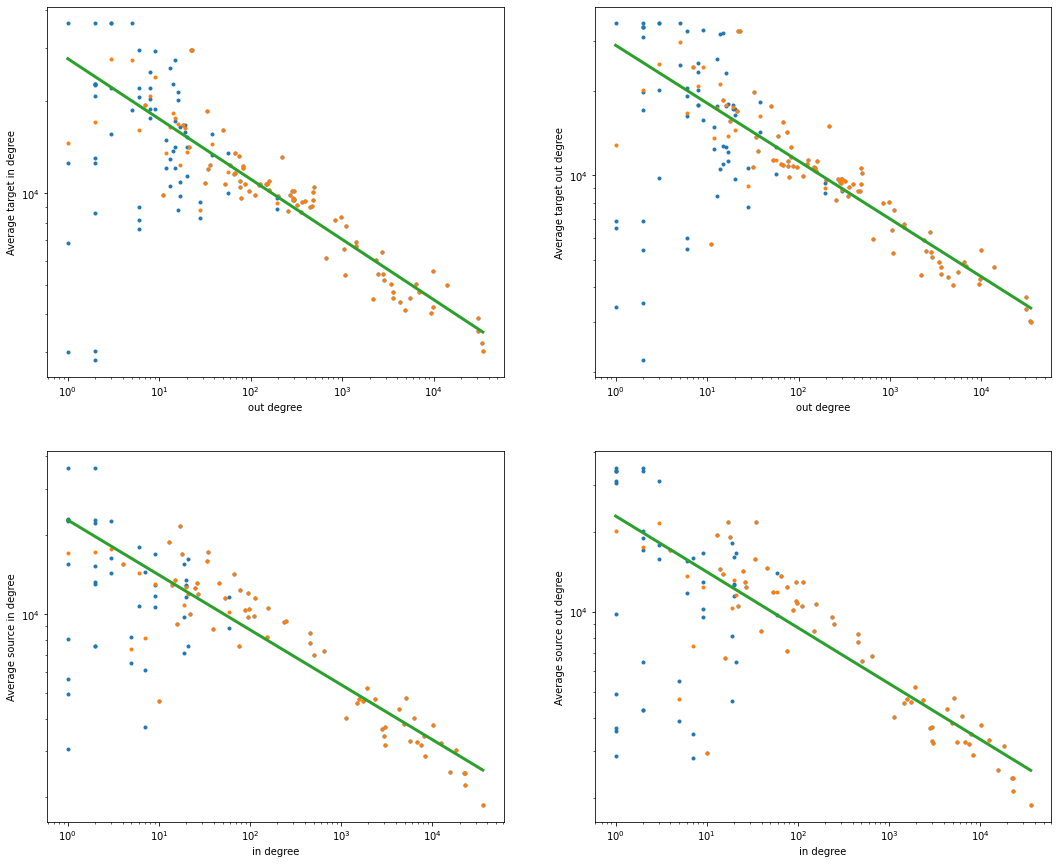

(-0.19762392162556142,
 -0.20560451452382256,
 -0.20933480935164436,
 -0.20970160450386402)

In [11]:
edges = country_df[['source','target']].copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

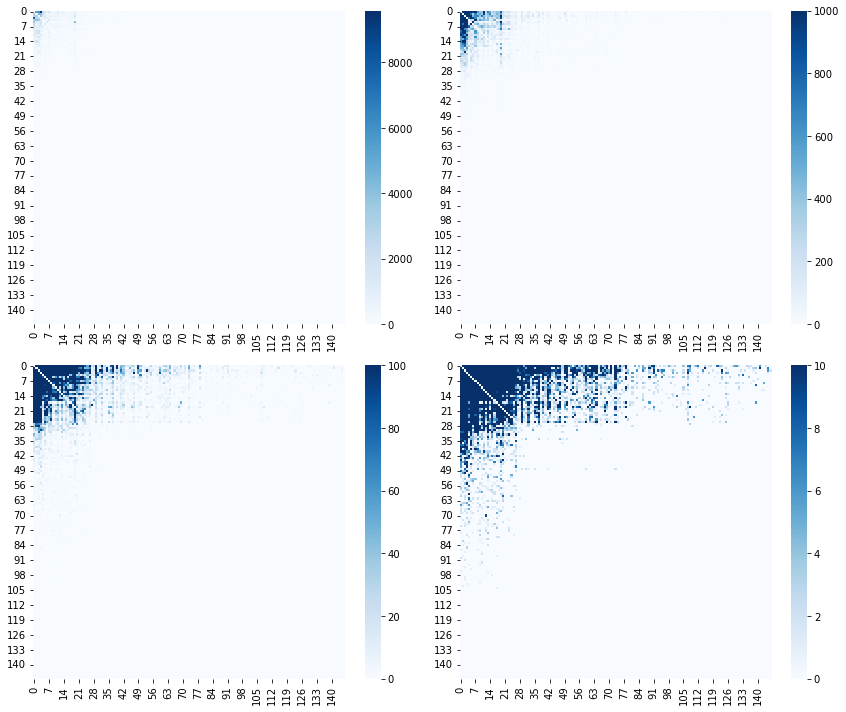

In [12]:
# label = 'PageRank autority position'
label = 'in degree position'
c = country_df.drop(['SendId', 'RecId'],axis=1)
another_order = scores[['Nodes', label]].copy()
another_order[label] = another_order[label] - 1
another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="source")
another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="target")
c_serie = c.groupby(['source ID', 'target ID']).sum()
row = np.array(c_serie.index.get_level_values(1).tolist())
col = np.array(c_serie.index.get_level_values(0).tolist())
val = c_serie.values
or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

ns.visualize_adj(or_adj)

The plot highlights differences between the adjacency matrix and the transpose one. It can explain disassortativity.

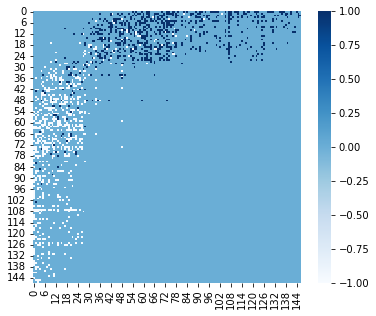

In [13]:
matr = or_adj.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()

This is only a draft version of community detection

In [14]:
import networkx as nx
# import community

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])


,Nodes,Community
4,Austria,0
9,Mozambique,0
10,Costa Rica,0
16,Ethiopia,0
19,Côte d'Ivoire,0
...,...,...
139,Trinidad and Tobago,0
140,Hong Kong,0
141,Nepal,0
143,Cameroon,0


,Nodes,Community
0,"Tanzania, United Republic of",1
6,Luxembourg,1
7,Iceland,1
8,Norway,1
11,Sweden,1
...,...,...
119,Lithuania,1
128,Georgia,1
129,UK,1
134,Egypt,1


,Nodes,Community
1,Belgium,2
3,"Moldova, Republic of",2
27,Rwanda,2
28,Uganda,2
30,Sri Lanka,2
42,United States,2
51,Nicaragua,2
58,Albania,2
60,Azerbaijan,2
67,Papua New Guinea,2


,Nodes,Community
5,Dominican Republic,3
12,Sudan,3
23,Tunisia,3
31,Libya,3
38,Kazakhstan,3
45,Turkey,3
55,"Korea, Republic of",3
57,Latvia,3
61,Portugal,3
64,Timor-Leste,3


,Nodes,Community
2,nan,4


## Geographic Heat map 

In [15]:
import geopandas as gpd

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

In [16]:
# adding code country to scores dataframe
countries_codes = nodes_df
countries_codes['code'] = nodes
scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# adding Switzerland since there is no Erasmus data
sw = {'Nodes':'Switzerland', 'code':'CH', 'in degree':0, 'out degree':0, 'hits hub':0, 'hits autority':0,
       'PageRank hub':0, 'PageRank authority':0, 'in degree position':0,
       'out degree position':0, 'hits hub position':0, 'hits autority position':0,
       'PageRank hub position':0, 'PageRank authority position':0}
scores_merge = scores_merge.append(sw, ignore_index = True)

merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
merged_df.dropna(subset=['Nodes'], inplace=True)

In [17]:
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']
# Russia has not been taken in consideration since it was too big to show and has very low exchanges

european_df = merged_df[merged_df['country'].isin(european_countries)]

# Countries ordered by PageRank hub score
display(european_df[['country', 'PageRank hub']].sort_values('PageRank hub', ascending=False))
# Countries ordered by PageRank authority score
display(european_df[['country', 'PageRank authority']].sort_values('PageRank authority', ascending=False))

,country,PageRank hub
34,Spain,0.109555
26,Germany,0.108978
54,Italy,0.097891
76,France,0.089319
45,Turkey,0.043546
...,...,...
3,Moldova,0.002014
84,Belarus,0.001926
115,Montenegro,0.001711
14,Liechtenstein,0.001487


,country,PageRank authority
34,Spain,0.127210
26,Germany,0.086031
76,France,0.084201
54,Italy,0.080548
129,United Kingdom,0.062429
...,...,...
115,Montenegro,0.001122
25,Kosovo,0.001115
84,Belarus,0.001110
3,Moldova,0.001080


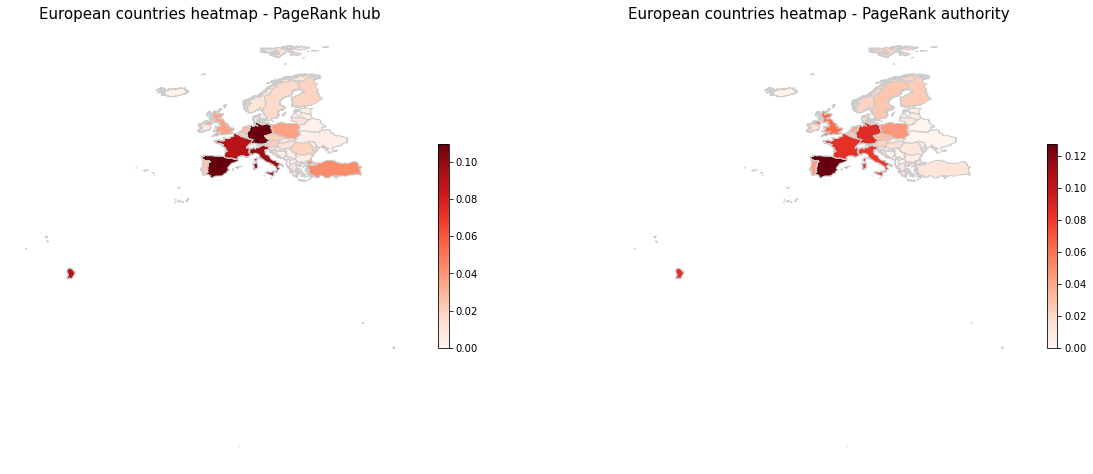

In [18]:
# deg_list = ['in degree', 'out degree', 'PageRank hub', 'PageRank autority']
#fig4, ax4 = plt.subplots(1,4, figsize=(20,15))
plt_list = ['PageRank hub', 'PageRank authority']
fig4, ax4 = plt.subplots(1,2, figsize=(20,15))

for i in range(len(plt_list)):
    european_df.plot(column=plt_list[i], ax=ax4[i], edgecolor='0.8', linewidth=1, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[plt_list[i]].min(), 
                                              vmax=european_df[plt_list[i]].max()), cmap='Reds')
    ax4[i].axis('off')
    fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
    ax4[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)

# ax4 = np.reshape(ax4, (2,2))
# plt.savefig('eu_pagerank.png')

## Erasmus exchanges vs total students enrolled per country

In [19]:
# dataset containing for each european university the students enrolled in ISCED 5-7 (tertiary education and master degree)
isced57_df = pd.read_csv("eter-export-2016.csv", delimiter=';', on_bad_lines='skip')
isced57_df.dropna(inplace=True)
for index in range(len(isced57_df['Institution Name'])):
    if isced57_df.iat[index,0] != isced57_df.iat[index,0].upper():
        isced57_df.iat[index,0] = isced57_df.iat[index,0].upper()
        
# dropping all the values having too many numbers after comma
mask = isced57_df['Total students enrolled ISCED 5-7'].str.contains(',', na=False)
isced57_df = isced57_df[~mask]

# dropping rows with undefined values
isced57_df = isced57_df[~isced57_df['Total students enrolled ISCED 5-7'].isin(['m','a','c','xr','s'])]

# changing country codes accordingly to european_df ones
isced57_df['Country Code'][isced57_df['Country Code'] == 'GR'] = 'EL'

isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].astype(float)
isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].round()
# count total number of enrolled students for each country
isced57_df = isced57_df.groupby(['Country Code'])['Total students enrolled ISCED 5-7'].sum().reset_index()

european_df_w = pd.merge(left=isced57_df, right=european_df, how='right', left_on='Country Code', right_on='iso2_code')
european_df_w = gpd.GeoDataFrame(european_df_w, geometry = 'geometry')

print('Top 10 countries for students enrollment')
display(european_df_w[['country', 'Total students enrolled ISCED 5-7']].sort_values('Total students enrolled ISCED 5-7',
                                                                                    ascending=False).head(10))

Top 10 countries for students enrollment


,country,Total students enrolled ISCED 5-7
17,Turkey,7107650.0
12,Germany,2625241.0
38,United Kingdom,2263020.0
19,Italy,1797986.0
13,Spain,1491419.0
30,Poland,1418588.0
33,Netherlands,720583.0
37,Greece,704969.0
6,Sweden,438578.0
23,Portugal,323467.0


In [20]:
european_df_w['weight_pr_hub'] = european_df_w['PageRank hub']/european_df_w['Total students enrolled ISCED 5-7']
european_df_w['weight_pr_aut'] = european_df_w['PageRank authority']/european_df_w['Total students enrolled ISCED 5-7']

# threshold set because some countries had too big values wrt the average
european_df_w.loc[european_df_w['weight_pr_hub'] > 2*10**(-7), 'weight_pr_hub'] = 2*10**(-7)
european_df_w.loc[european_df_w['weight_pr_aut'] > 2*10**(-7), 'weight_pr_aut'] = 2*10**(-7)
# maybe set better this thresholds

eu_w_copy = european_df_w.copy()
eu_w_copy.dropna(inplace = True)
# Countries ordered by weighted PageRank hub score
eu_w_copy.sort_values('weight_pr_hub', ascending=False, inplace=True)
eu_w_copy.reset_index(drop=True, inplace=True)
display(eu_w_copy[['country', 'weight_pr_hub']])
# Countries ordered by weighted PageRank authority score
eu_w_copy.sort_values('weight_pr_aut', ascending=False, inplace=True)
eu_w_copy.reset_index(drop=True, inplace=True)
display(eu_w_copy[['country', 'weight_pr_aut']])


,country,weight_pr_hub
0,Luxembourg,2.000000e-07
1,Liechtenstein,2.000000e-07
2,Malta,1.615408e-07
3,Romania,1.417199e-07
4,Slovenia,1.026944e-07
5,Lithuania,1.007646e-07
6,Estonia,8.790258e-08
7,Belgium,8.692329e-08
8,Slovakia,7.897599e-08
9,Spain,7.345657e-08


,country,weight_pr_aut
0,Luxembourg,2.000000e-07
1,Malta,2.000000e-07
2,Liechtenstein,2.000000e-07
3,Slovenia,1.755364e-07
4,Portugal,1.335447e-07
5,Estonia,1.275060e-07
6,Belgium,1.089761e-07
7,Czechia,1.052977e-07
8,Finland,9.151670e-08
9,Lithuania,8.724522e-08


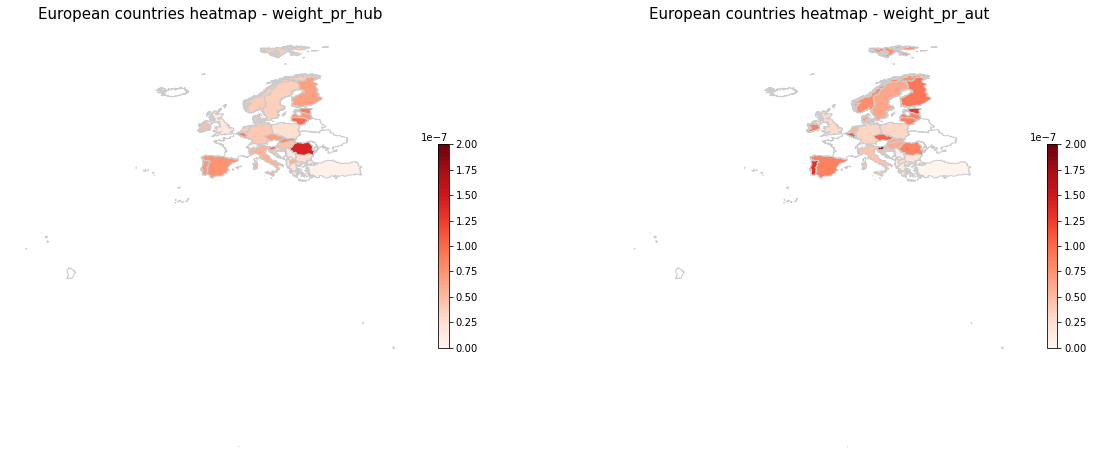

In [21]:
fig7, ax7 = plt.subplots(1,2, figsize=(20,15))
plt_list = ['weight_pr_hub', 'weight_pr_aut']
for i in range(len(plt_list)):
    # european_df_w.drop(european_df_w[plt_list[i]].idxmax(), inplace=True)
    european_df_w.plot(column=plt_list[i], ax=ax7[i], edgecolor='0.8', linewidth=1, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df_w[plt_list[i]].min(), 
                                              vmax=european_df_w[plt_list[i]].max()), cmap='Reds')
    ax7[i].axis('off')
    fig7.colorbar(sm, ax=ax7[i], shrink=0.25)
    ax7[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)
    
# plt.savefig('eu_pagerank_weight.png')

## GeoPlot for Communities

Text(0.5, 1.0, 'European countries - Commmunity')

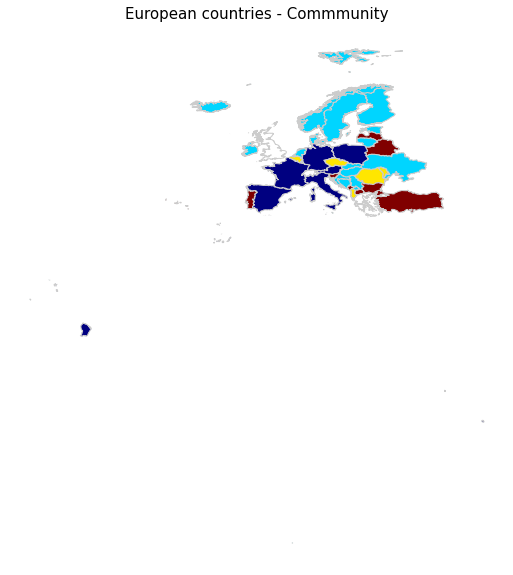

In [23]:
node_comm.loc[node_comm['Nodes'] == 'Moldova, Republic of', 'Nodes'] = 'Moldova'
node_comm.loc[node_comm['Nodes'] == 'North Macedonia', 'Nodes'] = 'Macedonia'
node_comm.loc[node_comm['Nodes'] == 'XK', 'Nodes'] = 'Kosovo'

eu_communities = european_df.copy()
eu_communities['Community'] = node_comm[node_comm['Nodes'].isin(european_countries)]['Community']

fig5, ax5 = plt.subplots(figsize=(10,10))
eu_communities.plot(column='Community', ax=ax5, edgecolor='0.8', linewidth=1, cmap='jet')
ax5.axis('off')
ax5.set_title('European countries - Commmunity', fontsize=15)

# plt.savefig('eu_community.png')